# Data Preparation

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("Ken_French_Data.csv", header=0, index_col=0, na_values=-99.99)

rets = data/100
rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')

#Paper uses excess return, therefore need to take risk-free rate off industry returns
d1 = rets
d1 = d1.drop(['Mkt-RF','RF'], 1)
d1 = d1.sub(rets['RF'], axis =0)
d1["Mkt-RF"] = rets["Mkt-RF"]

rets = d1

# Function Preparation


In [2]:
#Paper uses mean and std for expected return and volatility calculation
def monthly_rets(r):
    return r.mean()

def monthly_vol(r):
    return r.std()

def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol (weights, cov):
    return (weights.T @ cov @ weights)**0.5

#Risk free rate set to 0 as the data is already excess returns
def sharpe_ratio(r):
    sharpe = r.mean()/r.std()
    return sharpe

def weight_ew(r):
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    return ew

def mv_func(mean, cov):
    num_assets = cov.shape[0]
    inv_cov = np.linalg.pinv(cov)
    wtgs = (inv_cov@mean)/(np.ones((1,num_assets))@inv_cov@mean)
    return wtgs

def min_v_func(cov):
    num_assets = cov.shape[0]
    er = [1] * num_assets
    inv_cov = np.linalg.pinv(cov)
    wtgs = (inv_cov@er)/(np.ones((1,num_assets))@inv_cov@er)
    return wtgs


# Portfolio Constructions

In [3]:
#Equal-Weighted (1/N) Portfolio
PortRet= []  
for Date,ew in rets.iterrows():
    ew = weight_ew(rets).values    
    PortRet.append(ew@rets.loc[Date].values)

EW_Result = pd.DataFrame(PortRet, index = rets.index, columns =['ew'])

RW = 120

#In-sample Mean-Variance (MV-IS) Portfolio
f_mean = monthly_rets(rets)
f_cov = rets.cov()
#Generating weights
mv_wtgs_IS = mv_func(f_mean, f_cov)
#Multiplying weights with industries return
IS_MV = rets.mul(mv_wtgs_IS, axis=1).sum(axis=1)
#Returns of portfolio
IS_MV =pd.DataFrame(IS_MV, index = rets.index, columns =['Portfolio_return'])


#Out-of-sample Mean-Variance (MV-OoS) portfolio
#Rolling window for mean and variance
RW_mean = rets.rolling(RW, min_periods= RW).mean().dropna()
RW_cov = rets.rolling(RW, min_periods= RW).cov().dropna()
#Shifting date to match analysis dates as it is t-1
RW_mean = RW_mean.loc["1973-07":"2004-11"]
RW_cov = RW_cov.loc["1973-07": "2004-11"]
#Developing backtest system in a rolling window basis
OoS_MV = []
for Dates, w in RW_cov.groupby(level = "Date"):
    mean = RW_mean.loc[Dates]
    cov = RW_cov.loc[Dates,:].values
    w = mv_func(mean, cov)
    OoS_MV.append(w)    
OoS_MV = pd.DataFrame(OoS_MV, index= rets[RW:].index, columns = list(RW_mean))    
OoS_MV_rets = []
for Date, w in rets[RW:].iterrows():
    w = OoS_MV.loc[Date].values  
    OoS_MV_rets.append(w@rets.loc[Date].values)
#Returns of portfolio
OoS_MV_rets =pd.DataFrame(OoS_MV_rets, index = rets[RW:].index, columns =['Portfolio_return'])


#Out-of-sample Minimum-Variance (Min-OoS) Portfolio
#Developing backtest system in a rolling window basis
OoS_MinV = []
for Dates, w in RW_cov.groupby(level = "Date"):
    cov = RW_cov.loc[Dates,:].values
    w = min_v_func(cov)
    OoS_MinV.append(w)    
OoS_MinV = pd.DataFrame(OoS_MinV, index= rets[RW:].index, columns = list(RW_mean))    
OoS_MinV_rets = []
for Date, w in rets[RW:].iterrows():
    w = OoS_MinV.loc[Date].values  
    OoS_MinV_rets.append(w@rets.loc[Date].values) 
#Returns of portfolio
OoS_MinV_rets =pd.DataFrame(OoS_MinV_rets, index = rets[RW:].index, columns =['Portfolio_return'])

# Result of portfolio

In [4]:
import warnings
warnings.filterwarnings('ignore')

btr = pd.DataFrame({"1/N ": EW_Result["ew"],
                    "MV (IS)": IS_MV['Portfolio_return'],
                    "MV (OoS)": OoS_MV_rets["Portfolio_return"],
                    "Min (OoS)": OoS_MinV_rets['Portfolio_return']
                   })
%run 'Summary_stats.ipynb'
summary_stats(btr)

,Annualized Return,Annualized Vol,Sharpe Ratio,Skewness,Kurtosis,Max Drawdown
1/N,0.053850,0.145934,0.125229,-0.425117,5.008328,-0.527303
MV (IS),0.129268,0.192411,0.210754,0.147260,5.070350,-0.468934
MV (OoS),NaN,4.296456,0.076015,18.845663,362.434186,-3843.392023
Min (OoS),0.045563,0.110375,0.169816,0.035296,3.440839,-0.288761


<AxesSubplot:title={'center':'Cumulative wealth from $100'}, xlabel='Date'>

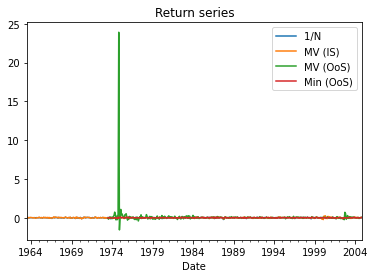

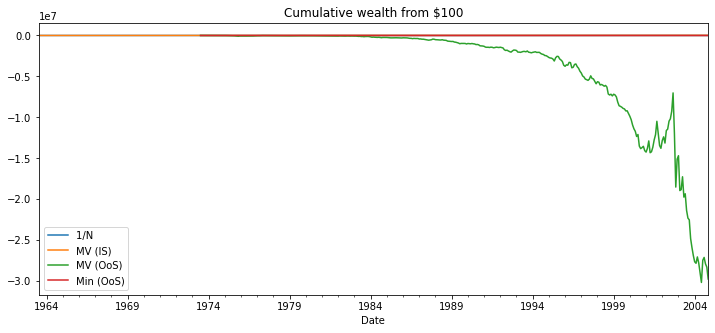

In [5]:
#Return Series of portfolios
btr.plot(title='Return series')

#Cumulative wealth by investing $100
(100*(1+btr).cumprod()).plot(figsize=(12,5), title = 'Cumulative wealth from $100')

<AxesSubplot:title={'center':'Cumulative wealth from $100'}, xlabel='Date'>

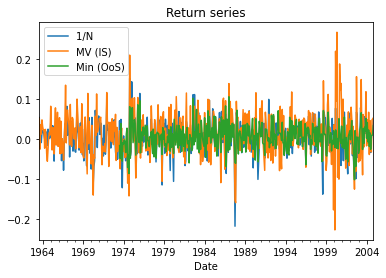

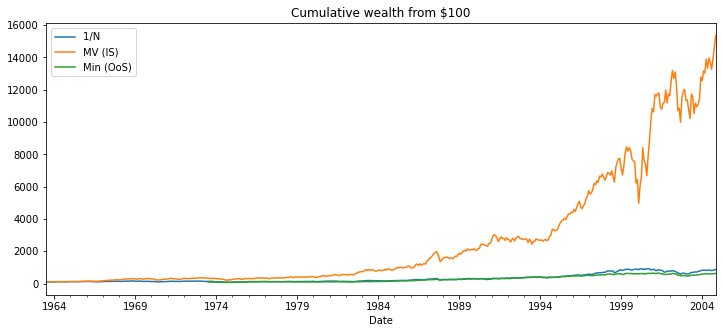

In [6]:
#Trying to remove MV (OoS) in order to remove outliers.
btr = pd.DataFrame({"1/N ": EW_Result["ew"],
                    "MV (IS)": IS_MV['Portfolio_return'],
                    #"MV (OoS)": OoS_MV_rets["Portfolio_returns"],
                    "Min (OoS)": OoS_MinV_rets['Portfolio_return']
                   })

#Return Series of portfolios
btr.plot(title='Return series')

#Cumulative wealth by investing $100
(100*(1+btr).cumprod()).plot(figsize=(12,5), title = 'Cumulative wealth from $100')


# Certain Equivalent Return (CEQ) Analysis

In [7]:
def ceq(r):
    gamma = 1
    return r.mean() - ((gamma/2) * r.var())

In [8]:
#Equal-weighted portfolio
ceq_ew = ceq(EW_Result["ew"])

#In-sample MV portfolio
ceq_IS_MV = ceq(IS_MV['Portfolio_return'])

#Out-of-sample MV portfolio
ceq_OoS_MV = ceq(OoS_MV_rets["Portfolio_return"])

#Out-of-sample Min-Variance portfolio
ceq_OoS_Min = ceq(OoS_MinV_rets['Portfolio_return'])

ceq_result = pd.DataFrame({'CEQ_Return': [ceq_ew, ceq_IS_MV, ceq_OoS_MV, ceq_OoS_Min]}, 
                 index = ['EW', 'IS_MV', 'OoS_MV', 'OoS_Min'])
ceq_result

#Result are sort of similar to Demiguel 2009 table 4 result.
#Demiguel result for EW, IS_MV, OoS_MV and OoS_Min are 0.005, 0.0106, -0.7816, 0.0052 respectively.

,CEQ_Return
EW,0.004388
IS_MV,0.010164
OoS_MV,-0.674868
OoS_Min,0.004903
